In [1]:
CONCRETENESS_RATINGS_PATH = './data/Concreteness_ratings_Brysbaert_et_al_BRM.txt'
import csv


# TODO? return a dict with struct of {id:, word: conc_rating: }
items = []
ratings_dict = {}
with open(CONCRETENESS_RATINGS_PATH, mode='r') as csv_file:
    csv_reader = csv.DictReader(csv_file, delimiter='\t')
    line_count = 0
    for row in csv_reader:
        word = row["Word"].lower()
        rating = row["Conc.M"]
        item = {"word": word,
                "concreteness": float(rating)
               }
        items.append(item)
        ratings_dict[word] = float(rating)

In [2]:
import numpy as np

with open('data/bnc_words_with_context_tokens_and_vectors.csv', mode='r') as infile:
    #reader = csv.reader(infile, delimiter="\t", quoting=csv.QUOTE_NONNUMERIC)
    reader = csv.reader(infile, delimiter="\t")

    centroids = {}
    num_tokens = {}

    token_count = 0
    for row in reader:
        token_count +=1
        
        if token_count % 100000 == 0:
            print("Processed %s tokens" % token_count)
        word = row[0]
        vector = np.fromstring(row[3][1:-1], dtype=np.float, sep=' ')
        if word in centroids:
            centroids[word] = (centroids[word] + vector)/2
            num_tokens[word] += 1
        else:
            centroids[word] = vector
            num_tokens[word] = 1

    print('Processed %s tokens in total' % token_count)
    print('the number of words is: %s' % len(centroids))


Processed 100000 tokens
Processed 200000 tokens
Processed 296820 tokens in total
the number of words is: 22623


In [3]:
# write centroids to file before we forget them
with open('data/brysbaert_words_with_bnc_centroids.csv', mode = 'w') as outfile:
    writer = csv.writer(outfile, delimiter='\t')

    for word, cent in centroids.items():
        writer.writerow([word, ratings_dict[word.lower()], cent, num_tokens[word]])

In [4]:
from scipy.spatial.distance import cosine

# if you don't have the centroids, try opening the file

with open('data/bnc_words_with_context_tokens_and_vectors.csv', mode='r') as infile:
    with open('data/bnc_words_with_context_tokens_and_vectors_and_distances.csv', mode='w') as outfile:
            reader = csv.reader(infile, delimiter="\t")
            writer = csv.writer(outfile, delimiter="\t")
            
            for row in reader:
                word = row[0]
                a = np.fromstring(row[3][1:-1], dtype=np.float, sep=' ')
                b = centroids[word]
                distance = 1 - cosine(a,b)
                # write word, text, concreteness, cosine distance from centroid
                writer.writerow([row[0], row[1], row[2], distance])


In [5]:
with open('data/bnc_words_with_context_tokens_and_vectors_and_distances.csv', mode='r') as infile:
    with open('data/brysbaert_words_with_avg_distance_from_centroids.csv', mode='w') as outfile:
        # word text concreteness cosine distance from centroid
        reader = csv.reader(infile, delimiter='\t')   
        writer = csv.writer(outfile, delimiter='\t')
        
        average_cosine = {}
        variance = {}

        token_count = 0
        
        for row in reader:
            token_count +=1
            if token_count % 100000 == 0:
                print("Processed %s tokens" % token_count)
            
            #debug
#             if token_count == 10:
#                 break
#             print(row)
            
            word = row[0]
            
            row[0] = word
            token_cosine = float(row[3])
            if word in average_cosine:
                average_cosine[word] = (average_cosine[word] + token_cosine)/2
                variance[word] = variance[word] + (token_cosine * token_cosine)

            else:
                average_cosine[word] = token_cosine
                variance[word] = 0

        print('Processed %s tokens in total' % token_count)
        print('the number of words is: %s' % len(average_cosine))
        
        # store average cosine distance from centroid
        for word,avg_cosine in average_cosine.items():
            writer.writerow([word, ratings_dict[word.lower()], avg_cosine, variance[word], num_tokens[word]])      
        


Processed 100000 tokens
Processed 200000 tokens
Processed 296820 tokens in total
the number of words is: 22623


In [6]:
# perform analysis 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df  = pd.read_csv("data/brysbaert_words_with_avg_distance_from_centroids.csv", sep='\t', names = ['word', 'concreteness', 'avg_distance_from_centroid', 'variance', 'num_tokens'], header=None)
print(df)
is_more_than_20= df['num_tokens'] >= 20
print(df)

print("filtered dataset")
df = df[is_more_than_20]
print(df)

#df.plot(kind='scatter',x='concreteness',y='avg_distance_from_centroid') # scatter plot
df.plot(kind='scatter',x='concreteness',y='variance') # scatter plot


            word  concreteness  avg_distance_from_centroid   variance  \
0            sat          3.88                    0.791599  19.497548   
1           back          4.33                    0.742308  13.008973   
2             in          3.00                    0.796351  15.729494   
3            her          3.00                    0.898047  20.154606   
4          chair          4.58                    0.902741  27.005470   
...          ...           ...                         ...        ...   
22618       cunt          4.21                    1.000000   0.000000   
22619  reflector          4.30                    1.000000   0.000000   
22620   solvency          1.89                    1.000000   0.000000   
22621   airstrip          4.68                    1.000000   0.000000   
22622       wilt          2.90                    1.000000   0.000000   

       num_tokens  
0              50  
1              50  
2              50  
3              50  
4              50  
...

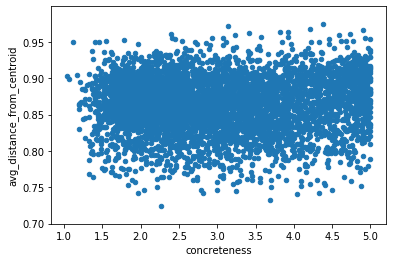

In [7]:
# scatter of average distance from centroid
df.plot(kind='scatter',x='concreteness',y='avg_distance_from_centroid') # scatter plot


In [8]:
## regrassion of concreteness x average distance from centroid
## Without a constant
import statsmodels.api as sm

X = df["concreteness"]
y = df["avg_distance_from_centroid"]


# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     OLS Regression Results                                    
===============================================================================================
Dep. Variable:     avg_distance_from_centroid   R-squared (uncentered):                   0.899
Model:                                    OLS   Adj. R-squared (uncentered):              0.899
Method:                         Least Squares   F-statistic:                          4.574e+04
Date:                        Thu, 05 Mar 2020   Prob (F-statistic):                        0.00
Time:                                12:11:58   Log-Likelihood:                         -656.89
No. Observations:                        5136   AIC:                                      1316.
Df Residuals:                            5135   BIC:                                      1322.
Df Model:                                   1                                                  
Covariance Type:                    nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
concreteness     0.2562      0.001    213.859      0.000       0.254       0.259
==============================================================================
Omnibus:                     1480.752   Durbin-Watson:                   1.647
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              304.287
Skew:                          -0.296   Prob(JB):                     8.41e-67
Kurtosis:                       1.965   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [9]:
## regression of concreteness x variance of distance from centroid
## With a constant
import statsmodels.api as sm

X = df["concreteness"]
y = df["variance"]
X = sm.add_constant(X) ## let's add an intercept (beta_0) to our model


# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               variance   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   0.02214
Date:                Thu, 05 Mar 2020   Prob (F-statistic):              0.882
Time:                        12:11:58   Log-Likelihood:                -16416.
No. Observations:                5136   AIC:                         3.284e+04
Df Residuals:                    5134   BIC:                         3.285e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           21.3588      0.260     82.043      0.000      20.848      21.869
concreteness     0.0121      0.081      0.149      0.882      -0.147       0.171
==============================================================================
Omnibus:                      510.030   Durbin-Watson:                   1.698
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              155.702
Skew:                          -0.095   Prob(JB):                     1.55e-34
Kurtosis:                       2.169   Cond. No.                         11.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
# pearsons correlation

from scipy.stats import pearsonr


X = df["concreteness"]
y = df["variance"]

pearson_value = pearsonr(X,y)

print("Pearson's correlation coefficient for concreteness and word-cloud varaince is {}".format(pearson_value))
print('N = {}'.format(len(df)))

Pearson's correlation coefficient for concreteness and word-cloud varaince is (0.0020765382762927033, 0.881726519332298)
N = 5136


How is the number of tokens we have affecting the variance?

In [11]:
X = df["num_tokens"]
y = df["variance"]

pearson_value = pearsonr(X,y)

print("Pearson's correlation coefficient for number of tokens and word-cloud varaince is {}".format(pearson_value))
print('N = {}'.format(len(df)))

## regression of num_tokens x variance of distance from centroid
## With a constant
import statsmodels.api as sm

X = sm.add_constant(X) ## let's add an intercept (beta_0) to our model

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()


Pearson's correlation coefficient for number of tokens and word-cloud varaince is (0.7957036934267318, 0.0)
N = 5136


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               variance   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                     8861.
Date:                Thu, 05 Mar 2020   Prob (F-statistic):               0.00
Time:                        12:11:58   Log-Likelihood:                -13841.
No. Observations:                5136   AIC:                         2.769e+04
Df Residuals:                    5134   BIC:                         2.770e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.4655      0.197     17.598      0.000       3.079       3.852
num_tokens     0.4320      0.005     94.131      0.000       0.423       0.441
==============================================================================
Omnibus:                       48.665   Durbin-Watson:                   1.835
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               58.933
Skew:                          -0.166   Prob(JB):                     1.60e-13
Kurtosis:                       3.406   Cond. No.                         169.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Clearly there is a large effect of the number of tokens we have on the variance of the word-type.

Let's do a multiple regression to see how much of the variance in variance is accounted for by concreteness rather than just N

In [12]:
X = df[["concreteness", "num_tokens"]]
y = df["variance"]
X = sm.add_constant(X) ## let's add an intercept (beta_0) to our model


model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               variance   R-squared:                       0.634
Model:                            OLS   Adj. R-squared:                  0.634
Method:                 Least Squares   F-statistic:                     4448.
Date:                Thu, 05 Mar 2020   Prob (F-statistic):               0.00
Time:                        12:11:58   Log-Likelihood:                -13835.
No. Observations:                5136   AIC:                         2.768e+04
Df Residuals:                    5133   BIC:                         2.769e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            2.8919      0.251     11.509      0.000       2.399       3.384
concreteness     0.1805      0.049      3.669      0.000       0.084       0.277
num_tokens       0.4327      0.005     94.316      0.000       0.424       0.442
==============================================================================
Omnibus:                       51.896   Durbin-Watson:                   1.833
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               60.986
Skew:                          -0.184   Prob(JB):                     5.72e-14
Kurtosis:                       3.387   Cond. No.                         218.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

So, a model using only num_tokens and a constant explains 60% of the variance in variance (lol), but a multiple regression model using num_tokens, concreteness, and a constant explains 63.6 % of the variance in the data. So does that mean that concreteness explains 3.6 percent of the variance, after you account for the difference in sample size?